In [64]:
import pandas as pd
df=pd.read_csv('train.csv')
df=df.drop(columns=['image_link'])
df.sample(6)

,sample_id,catalog_content,price
11000,247846,"Item Name: Alani Nu TROPSICLE Sugar Free, Low ...",2.48
11268,294745,Item Name: Heinz Apple Cider Vinegar 16 oz (Pa...,16.86
49306,106925,Item Name: Todd Bosley's World Famous Pineappl...,17.99
3656,275239,"Item Name: Frontier Whole Yellow Mustard Seed,...",10.91
26688,33179,"Item Name: Harney and Sons Peppermint Tea, 20 ...",13.13
66585,154010,Item Name: Folgers Simply Smooth Decaf Mild Ro...,14.95


In [65]:
import re
def clean_text(text):
    text=text.lower()
    text=re.sub(r"<.*?>"," ",text)
    text=re.sub(r'http\S+|www\S+|https\S+','',text)
    text=re.sub(r'[^a-zA-Z0-9\s]','',text)
    text=re.sub(r'\s+',' ',text).strip()
    return text

In [66]:
df['cleaned_text']=df['catalog_content'].apply(clean_text)

In [67]:
df['cleaned_text'].str.len()

0          83
1         490
2         313
3        1264
4         139
         ... 
74995     748
74996    1645
74997     132
74998     869
74999     273
Name: cleaned_text, Length: 75000, dtype: int64

In [68]:
df['cleaned_text'].str.split().str.len()

0         18
1         80
2         59
3        205
4         26
        ... 
74995    130
74996    271
74997     21
74998    134
74999     47
Name: cleaned_text, Length: 75000, dtype: int64

In [69]:
df['cleaned_text'].str.len().describe()

count    75000.000000
mean       866.888160
std        816.969425
min         25.000000
25%        235.000000
50%        608.000000
75%       1223.000000
max       7715.000000
Name: cleaned_text, dtype: float64

In [7]:
from sentence_transformers import SentenceTransformer
model=SentenceTransformer('bert-base-nli-mean-tokens')
text=df['cleaned_text'].to_list()
embeddings=model.encode(text,batch_size=32,show_progress_bar=True,convert_to_numpy=True)

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 2344/2344 [12:53<00:00,  3.03it/s]


In [ ]:
embeddings.shape

(75000, 768)

In [70]:
# Load the model (uses GPU automatically if available)
from sentence_transformers import SentenceTransformer
model=SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# Convert cleaned text into embeddings
texts2=df["cleaned_text"].tolist()

embeddings2=model.encode(
    texts2,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

print("Embedding shape:",embeddings2.shape)

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 2344/2344 [30:50<00:00,  1.27it/s] 


Embedding shape: (75000, 768)


In [71]:
df["desc_len"]=df["cleaned_text"].str.len()
df["word_count"]=df["cleaned_text"].str.split().str.len()
df["num_digits"]=df["cleaned_text"].str.count(r"\d")

In [80]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pca=PCA(n_components=300,random_state=42)
x_pca=pca.fit_transform(embeddings2)
kmeans=KMeans(n_clusters=121,random_state=42)
df['automated_category_ID']=kmeans.fit_predict(x_pca)

In [181]:
df['category_mean_price']=df.groupby('automated_category_ID')['price'].transform('median')

In [182]:
df[['category_mean_price','automated_category_ID']]

,category_mean_price,automated_category_ID
0,10.4900,15
1,9.8650,78
2,7.2075,96
3,6.0650,87
4,10.9900,17
...,...,...
74995,15.9650,38
74996,15.9900,109
74997,13.3550,37
74998,19.3400,83


In [183]:
df['category_mean_price'].describe()

count    75000.000000
mean        15.021575
std          9.018756
min          2.880000
25%          9.995000
50%         12.970000
75%         17.390000
max         64.480000
Name: category_mean_price, dtype: float64

In [184]:
df['price_category_ID']=KMeans(n_clusters=5,random_state=42).fit_predict(df[['price']])

In [185]:
df['automated_category_ID'].value_counts()

automated_category_ID
111    1480
20     1260
113    1202
98     1182
60     1131
       ... 
59      210
18      194
120     183
4       153
103     128
Name: count, Length: 121, dtype: int64

In [186]:
df.where(df['automated_category_ID']==111).dropna()

,sample_id,catalog_content,price,cleaned_text,desc_len,word_count,num_digits,automated_category_ID,price_category_ID,category_mean_price
56,147811.0,Item Name: Zabaglione Strawberry Pu-erh Tea (5...,57.70,item name zabaglione strawberry puerh tea 50 t...,2356.0,386.0,29.0,111.0,1.0,46.64
127,144305.0,Item Name: Maraschino Cherry Oolong Tea (50 te...,56.01,item name maraschino cherry oolong tea 50 tea ...,2341.0,390.0,29.0,111.0,1.0,46.64
144,142282.0,"Item Name: Raspberry Oolong Tea (50 tea bags, ...",38.54,item name raspberry oolong tea 50 tea bags zin...,2213.0,377.0,29.0,111.0,1.0,46.64
180,20013.0,Item Name: Orange Lemongrass Dandelion Root Te...,33.50,item name orange lemongrass dandelion root tea...,2407.0,395.0,28.0,111.0,1.0,46.64
186,2511.0,Item Name: Mandarin Orange White Tea (Loose) (...,50.76,item name mandarin orange white tea loose 8 oz...,2315.0,395.0,26.0,111.0,1.0,46.64
...,...,...,...,...,...,...,...,...,...,...
74850,149043.0,Item Name: Orange Lemon White Tea (25 tea bags...,26.09,item name orange lemon white tea 25 tea bags z...,2298.0,391.0,27.0,111.0,1.0,46.64
74867,144874.0,Item Name: Peppermint Lemongrass White Tea (Lo...,57.63,item name peppermint lemongrass white tea loos...,2325.0,385.0,27.0,111.0,1.0,46.64
74913,55096.0,Item Name: Nelson's Tea - Peach Raspberry Punc...,8.99,item name nelsons tea peach raspberry punch ro...,1169.0,189.0,13.0,111.0,0.0,46.64
74930,143958.0,"Item Name: Panettone Black Tea (25 tea bags, Z...",16.77,item name panettone black tea 25 tea bags zin ...,2295.0,385.0,27.0,111.0,0.0,46.64


In [187]:
df.where((df['automated_category_ID']==111) & (df['price_category_ID']==4)).dropna()

,sample_id,catalog_content,price,cleaned_text,desc_len,word_count,num_digits,automated_category_ID,price_category_ID,category_mean_price
7812,195359.0,Item Name: Sakura Cherry Rose White Tea (Loose...,211.00,item name sakura cherry rose white tea loose 4...,1085.0,200.0,33.0,111.0,4.0,46.64
70759,195230.0,Item Name: Oasis Mango White Tea (Loose) (8 oz...,238.91,item name oasis mango white tea loose 8 oz zin...,1071.0,198.0,33.0,111.0,4.0,46.64


In [188]:
df['price_category_ID'].value_counts()

price_category_ID
0    53804
1    17098
2     3749
4      344
3        5
Name: count, dtype: int64

In [189]:
df.where(df['price_category_ID']==2).dropna()

,sample_id,catalog_content,price,cleaned_text,desc_len,word_count,num_digits,automated_category_ID,price_category_ID,category_mean_price
7,222007.0,Item Name: VineCo Original Series Chilean Sauv...,94.00,item name vineco original series chilean sauvi...,2230.0,354.0,11.0,94.0,2.0,22.9900
15,266475.0,Item Name: Organic Vinegar; Apple Cider\nValue...,81.44,item name organic vinegar apple cider value 10...,59.0,11.0,4.0,44.0,2.0,12.9900
18,271423.0,Item Name: BulkSupplements.com Trehalose Powde...,109.97,item name bulksupplementscom trehalose powder ...,2757.0,433.0,18.0,36.0,2.0,12.8900
20,267410.0,"Item Name: Food to Live Black-Eyed Peas, 25 Po...",98.99,item name food to live blackeyed peas 25 pound...,1604.0,281.0,16.0,95.0,2.0,14.0375
38,196576.0,Item Name: Buchu Leaf (Organic) Tea (Loose) (4...,124.52,item name buchu leaf organic tea loose 4 oz zi...,577.0,101.0,32.0,40.0,2.0,41.8700
...,...,...,...,...,...,...,...,...,...,...
74875,263110.0,"Item Name: Yocream Yogurt Mix, Cookies and Cre...",107.24,item name yocream yogurt mix cookies and cream...,104.0,20.0,5.0,78.0,2.0,9.8650
74895,204173.0,Item Name: Tropical Mixed Dried Fruit Medley -...,89.99,item name tropical mixed dried fruit medley by...,2925.0,484.0,17.0,100.0,2.0,19.5400
74926,247833.0,Item Name: Bloomingmore | Fresh Cut Gypsophili...,105.98,item name bloomingmore fresh cut gypsophilia 1...,1576.0,258.0,17.0,66.0,2.0,64.4800
74959,52787.0,Item Name: Love and Quiches 1/4 Sheet Special ...,116.44,item name love and quiches 14 sheet special oc...,104.0,19.0,8.0,92.0,2.0,7.9900


In [190]:
df['price'].where(df['price_category_ID']==3).dropna().describe()

count       5.000000
mean     1439.208000
std       771.543098
min       921.500000
25%      1010.540000
50%      1188.000000
75%      1280.000000
max      2796.000000
Name: price, dtype: float64

In [277]:
for i in range(5):
    print(f"Price Category ID: {i}")
    display(df['price'].where(df['price_category_ID']==i).dropna().describe())

Price Category ID: 0


count    12687.000000
mean         4.629964
std          1.016626
min          2.880000
25%          3.790000
50%          4.640000
75%          5.490000
max          6.480000
Name: price, dtype: float64

Price Category ID: 1


count    23299.000000
mean        21.723913
std          5.626147
min         13.940000
25%         16.950000
50%         20.630000
75%         26.090000
max         33.885000
Name: price, dtype: float64

Price Category ID: 2


count    18953.000000
mean         9.865058
std          2.089916
min          6.485000
25%          7.990000
50%          9.920000
75%         11.680000
max         13.935000
Name: price, dtype: float64

Price Category ID: 3


count    15007.000000
mean        67.423384
std         53.719746
min         33.890000
25%         40.390000
50%         52.270000
75%         75.652500
max       2796.000000
Name: price, dtype: float64

Price Category ID: 4


count    5054.000000
mean        1.957476
std         0.560907
min         0.130000
25%         1.530000
50%         1.990000
75%         2.460000
max         2.875000
Name: price, dtype: float64

In [201]:
tab_feats=df[['desc_len','word_count','num_digits','automated_category_ID','category_mean_price']].values

In [273]:
import numpy as np
x=np.hstack([embeddings,tab_feats])
y=df["price"]
#x2=np.hstack([embeddings2,tab_feats])

In [274]:
#x=np.log1p(np.log1p(x))
y=np.log1p(np.log1p(y))
df['reduced_price']=y
#x2=np.log1p(np.log1p(x2))

In [275]:
df['price_category_ID']=KMeans(n_clusters=5,random_state=42).fit_predict(df[['reduced_price']])

In [278]:
pd.DataFrame(x).describe()

,0,1,2,3,4,5,6,7,8,9,...,764,765,766,767,768,769,770,771,772,773
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,...,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000
mean,-0.768743,0.981656,-0.849260,0.075294,0.211644,-0.929654,0.227844,0.258686,0.518962,-0.341166,...,0.073654,-0.117545,0.356634,0.164734,866.888160,145.625160,14.505960,60.846667,15.021575,0.298867
std,0.324655,0.306574,0.417551,0.189699,0.280356,0.355002,0.487686,0.375055,0.266908,0.304837,...,0.207215,0.327481,0.408655,0.238027,816.969425,134.862567,8.531221,35.140680,9.018756,0.582297
min,-1.808311,-0.331592,-2.439052,-0.921851,-0.890438,-2.107126,-1.403423,-1.589805,-0.896705,-1.428295,...,-0.920758,-1.830568,-1.400120,-0.872885,25.000000,6.000000,0.000000,0.000000,2.880000,0.000000
25%,-0.995073,0.783355,-1.126740,-0.041104,0.008777,-1.174639,-0.114017,0.004275,0.365352,-0.551613,...,-0.056810,-0.330589,0.055013,0.009256,235.000000,41.000000,8.000000,30.000000,9.995000,0.000000
50%,-0.801302,0.989269,-0.858102,0.081057,0.188742,-0.959499,0.216020,0.234608,0.545926,-0.343593,...,0.084015,-0.116298,0.340806,0.169028,608.000000,103.000000,13.000000,60.000000,12.970000,0.000000
75%,-0.577487,1.191023,-0.583814,0.197945,0.392063,-0.723099,0.546405,0.487436,0.703474,-0.145283,...,0.213204,0.101598,0.639913,0.326693,1223.000000,204.000000,19.000000,93.000000,17.390000,0.000000
max,0.841826,2.322398,1.278879,1.055276,1.470654,1.057010,2.262991,1.991799,1.442846,1.242883,...,0.883568,1.315381,1.961597,1.056484,7715.000000,1330.000000,186.000000,120.000000,64.480000,4.000000


In [220]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=42)

In [221]:
from xgboost import XGBRegressor
xgb=XGBRegressor(n_estimators=2500,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.4,
    tree_method='hist',
    random_state=42)
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [222]:
y_xgb=xgb.predict(x_val)
np.expm1(np.expm1(y_xgb))

array([13.18256  , 40.5841   , 10.3667965, ...,  7.5740223, 11.268506 ,
        6.9838533], dtype=float32)

In [223]:
np.expm1(np.expm1(y_val))

array([12.195, 38.54 , 17.86 , ...,  3.34 ,  6.63 , 26.95 ])

In [298]:
def smape(y_true,y_pred):
    return np.mean(2*np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)))*100

y_xgb=xgb.predict(x_val)
score=smape(np.expm1(np.expm1(y_val)),np.expm1(np.expm1(y_xgb)))
print("SMAPE:", score)

SMAPE: 58.30856894254119


In [296]:
testx=x[0:14380]
testy=y[0:14380]

In [297]:
predy=xgb.predict(testx)
smape(np.expm1(np.expm1(testy)),np.expm1(np.expm1(predy)))

15.651930132444003

In [33]:
np.expm1(np.expm1(testy))

array([ 4.89, 13.12,  1.97, ..., 18.95,  3.49, 19.99])

In [34]:
np.expm1(np.expm1(predy))

array([ 5.085075 , 12.56001  ,  1.9867314, ..., 13.092974 ,  4.176988 ,
       18.42844  ], dtype=float32)

In [280]:
tab_feats=df[['desc_len','word_count','num_digits','automated_category_ID','category_mean_price']].values

In [281]:
import numpy as np
x=np.hstack([embeddings,tab_feats])
y=df["price_category_ID"]
#x2=np.hstack([embeddings2,tab_feats])

In [282]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=42)

In [283]:
from xgboost import XGBClassifier
xgbc=XGBClassifier(n_estimators=2500,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.4,
    tree_method='hist',
    random_state=42)
xgbc.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [237]:
from catboost import CatBoostClassifier
catb=CatBoostClassifier(iterations=2000,
    learning_rate=0.02,
    depth=8,
    random_seed=42,
    verbose=100)
catb.fit(x_train,y_train)

0:	learn: 1.5713715	total: 700ms	remaining: 23m 20s
100:	learn: 0.7370423	total: 52.3s	remaining: 16m 24s
200:	learn: 0.6607390	total: 1m 49s	remaining: 16m 21s
300:	learn: 0.6338812	total: 2m 53s	remaining: 16m 18s
400:	learn: 0.6151172	total: 3m 58s	remaining: 15m 52s
500:	learn: 0.5997475	total: 5m 2s	remaining: 15m 4s
600:	learn: 0.5848601	total: 6m 3s	remaining: 14m 6s
700:	learn: 0.5706488	total: 7m 4s	remaining: 13m 6s
800:	learn: 0.5574694	total: 8m 5s	remaining: 12m 6s
900:	learn: 0.5454197	total: 9m 4s	remaining: 11m 4s
1000:	learn: 0.5341795	total: 10m 4s	remaining: 10m 3s
1100:	learn: 0.5233641	total: 11m 3s	remaining: 9m 2s
1200:	learn: 0.5131290	total: 12m 3s	remaining: 8m 1s
1300:	learn: 0.5036229	total: 13m 2s	remaining: 7m
1400:	learn: 0.4944306	total: 14m 2s	remaining: 6m
1500:	learn: 0.4851858	total: 15m 1s	remaining: 4m 59s
1600:	learn: 0.4763684	total: 16m 1s	remaining: 3m 59s
1700:	learn: 0.4678360	total: 17m 1s	remaining: 2m 59s
1800:	learn: 0.4591990	total: 18m 

In [ ]:
y_xgbc=xgbc.predict(x_val)
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_val,y_xgbc)
print("Accuracy:",accuracy)

Accuracy: 0.4755333333333333


In [236]:
accuracy

0.7684666666666666

In [238]:
y_catb=catb.predict(x_val)
accuracy_catb=accuracy_score(y_val,y_catb)
accuracy_catb

0.7562666666666666

In [285]:
df['new_price_category_ID']=xgbc.predict(x)

<Axes: xlabel='price_category_ID', ylabel='count'>

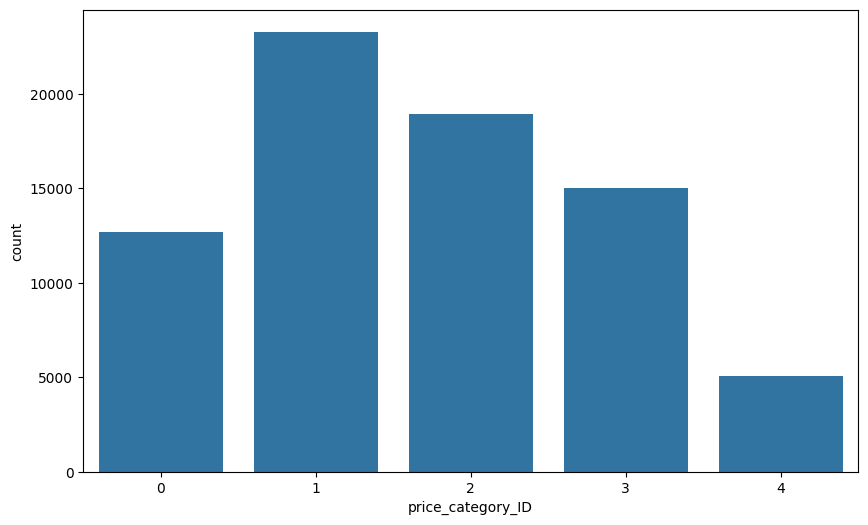

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.countplot(x='price_category_ID',data=df)

<Axes: xlabel='new_price_category_ID', ylabel='count'>

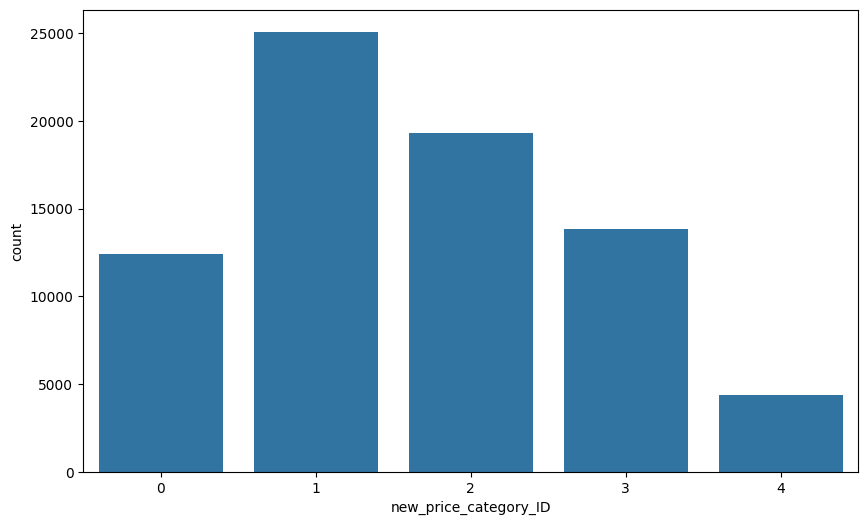

In [287]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.countplot(x='new_price_category_ID',data=df)

In [290]:
for i in range(5):
    print(f"Price Category ID: {i}")
    display(df['price'].where(df['new_price_category_ID']==i).dropna().describe())

Price Category ID: 0


count    12407.000000
mean         6.125762
std          9.181769
min          0.460000
25%          3.790000
50%          4.750000
75%          5.700000
max        293.700000
Name: price, dtype: float64

Price Category ID: 1


count    25091.000000
mean        22.178150
std         14.021842
min          0.360000
25%         15.930000
50%         19.990000
75%         26.490000
max        600.590000
Name: price, dtype: float64

Price Category ID: 2


count    19331.000000
mean        11.274084
std         10.911794
min          0.380000
25%          7.950000
50%          9.960000
75%         11.990000
max        413.990000
Name: price, dtype: float64

Price Category ID: 3


count    13819.000000
mean        66.046235
std         54.832779
min          0.630000
25%         39.990000
50%         51.605000
75%         75.340000
max       2796.000000
Name: price, dtype: float64

Price Category ID: 4


count    4352.000000
mean        2.405222
std         4.693309
min         0.130000
25%         1.540000
50%         1.990000
75%         2.480000
max       128.890000
Name: price, dtype: float64

In [291]:
df['new_price_category_ID'].value_counts()

new_price_category_ID
1    25091
2    19331
3    13819
0    12407
4     4352
Name: count, dtype: int64

In [292]:
tab_feats=df[['desc_len','word_count','num_digits','automated_category_ID','category_mean_price','new_price_category_ID']].values
x=np.hstack([embeddings,tab_feats])
y=df["price"]

In [293]:
y=np.log1p(np.log1p(y))

In [294]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=42)

from xgboost import XGBRegressor
xgb=XGBRegressor(n_estimators=2500,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.4,
    tree_method='hist',
    random_state=42)
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [295]:
def smape(y_true,y_pred):
    return np.mean(2*np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)))*100

y_xgb=xgb.predict(x_val)
score=smape(np.expm1(np.expm1(y_val)),np.expm1(np.expm1(y_xgb)))
print("SMAPE:", score)

SMAPE: 58.30856894254119
